In [2]:
import sys
sys.path.append("..")
from diskit.circuit_remapper import *
from diskit.components.layer import *
from qiskit import assemble, Aer
from qiskit.visualization import plot_bloch_multivector
import warnings

warnings.filterwarnings("ignore")

### Create a Distributed Circuit for a CNOT

Define a Topology

In [3]:
circuit_topo = Topology()
circuit_topo.create_qmap(2, [2, 3],"sys_cnot")
circuit_topo.qmap, circuit_topo.emap

({'sys_cnot0': [Qubit(QuantumRegister(2, 'sys_cnot0'), 0),
   Qubit(QuantumRegister(2, 'sys_cnot0'), 1)],
  'sys_cnot1': [Qubit(QuantumRegister(3, 'sys_cnot1'), 0),
   Qubit(QuantumRegister(3, 'sys_cnot1'), 1),
   Qubit(QuantumRegister(3, 'sys_cnot1'), 2)]},
 {'sys_cnot0': Qubit(QuantumRegister(1, 'com_sys_cnot0'), 0),
  'sys_cnot1': Qubit(QuantumRegister(1, 'com_sys_cnot1'), 0)})

Get the registers

In [4]:
qregs = circuit_topo.get_regs()

Define the monolithic Circuit

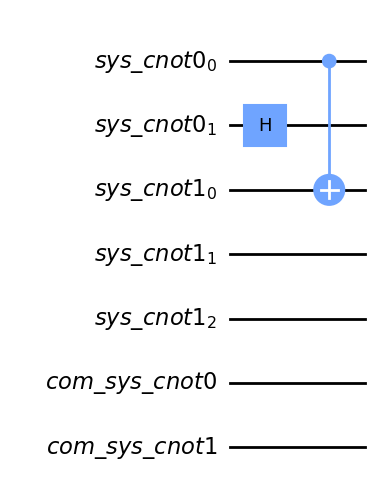

In [5]:
qc = QuantumCircuit(*qregs)
qc.h(1)
qc.cx(0,2)
qc.draw('mpl')

Create the remapper object based on topology defined

In [6]:
remapper = CircuitRemapper(circuit_topo)

Convert the monolithic circuit to a Distributed circuit

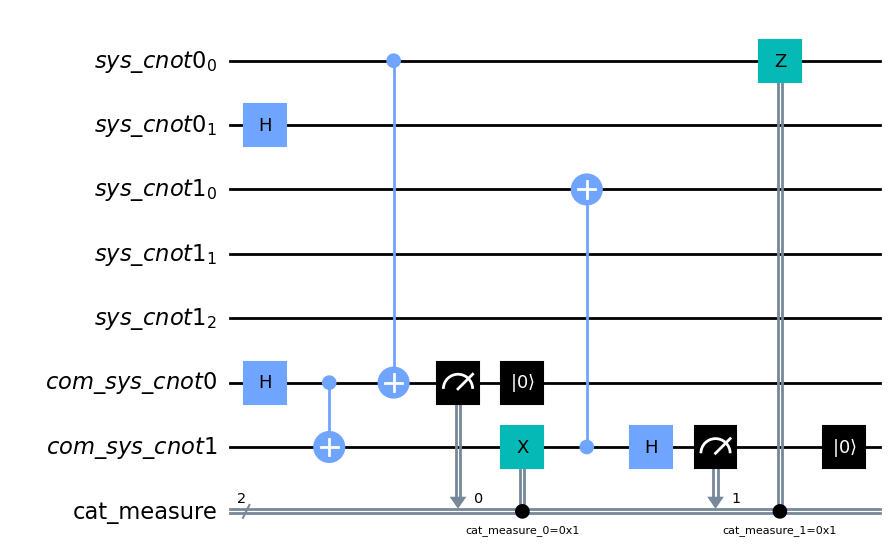

In [7]:
dist_circ = remapper.remap_circuit(qc)
dist_circ.draw(output='mpl')

If there are consecutive gates with same control but with target on the same processor, we can do the distribution only once. Let's look at the following example.

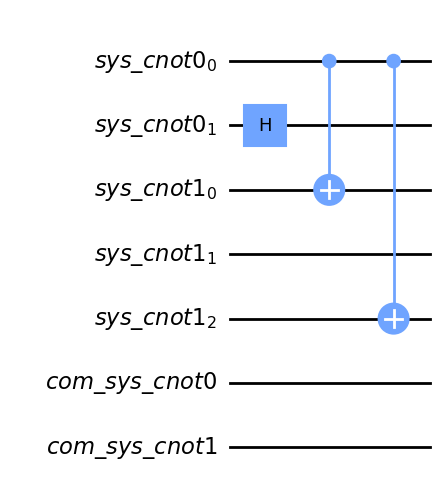

In [8]:
qc2 = QuantumCircuit(*qregs)
qc2.h(1)
qc2.cx(0,2)
qc2.cx(0,4)
qc2.draw('mpl')

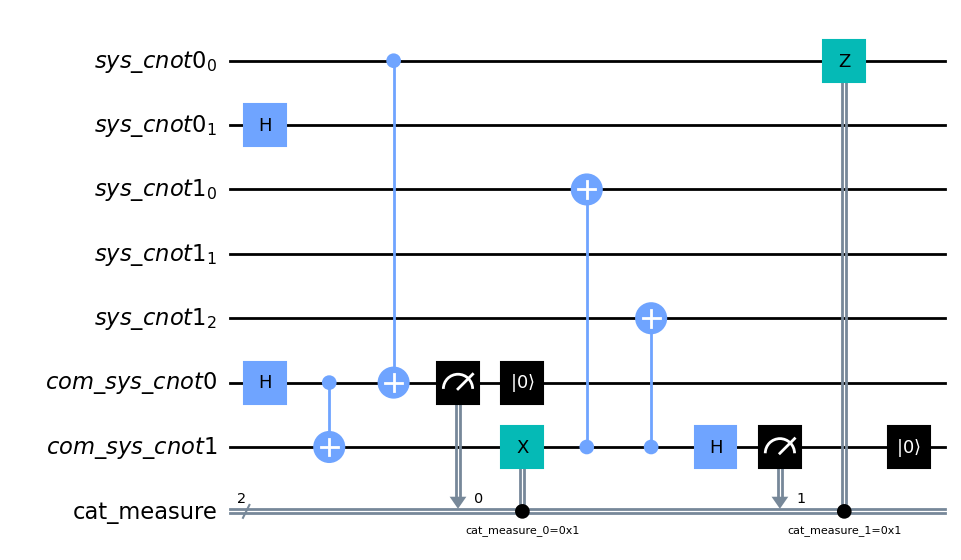

In [9]:
dist_circ2 = remapper.remap_circuit(qc2)
dist_circ2.draw(output='mpl')

Let us check the validity of the working of the distributed version

First we check the output for monolithic circuit

In [10]:
from qiskit.quantum_info import partial_trace

In [11]:
sim = Aer.get_backend('aer_simulator')

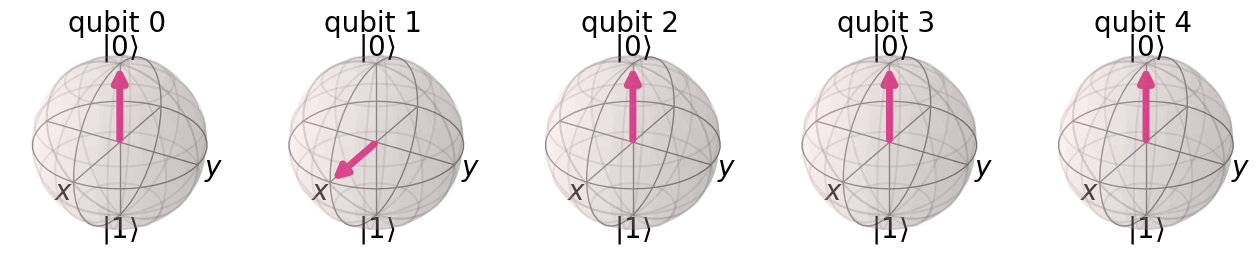

In [12]:
qc2_copy = qc2.copy()
qc2_copy.save_statevector()
qobj = assemble(qc2_copy)
state = sim.run(qobj).result().get_statevector()

state = partial_trace(state, [5,6]) ## Trace out the communication qubits

plot_bloch_multivector(state)

Now We check output of the distributed circuit

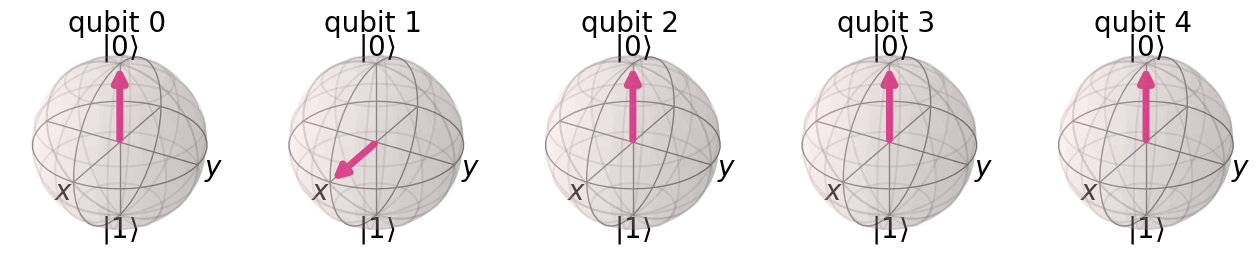

In [13]:
dqc2_copy = dist_circ2.copy()
dqc2_copy.save_statevector()
qobj = assemble(dqc2_copy)
state = sim.run(qobj).result().get_statevector()

state = partial_trace(state, [5,6]) ## Trace out the communication qubits

plot_bloch_multivector(state)

As can be seen, the output of both circuits are equivalent

### The case of higher order gates
In the case of gates with more than 2 qubits, we shall need to decompose the circuit to 2 and 1 qubit gates for the distribution to work

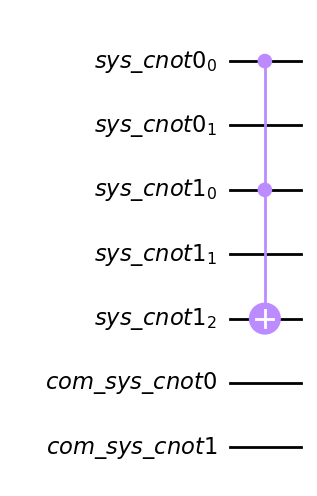

In [14]:
qregs = circuit_topo.get_regs()
qc = QuantumCircuit(*qregs)
qc.ccx(0, 2, 4)
qc.draw('mpl')

Trying to distribute the above circuit shall result in an error.

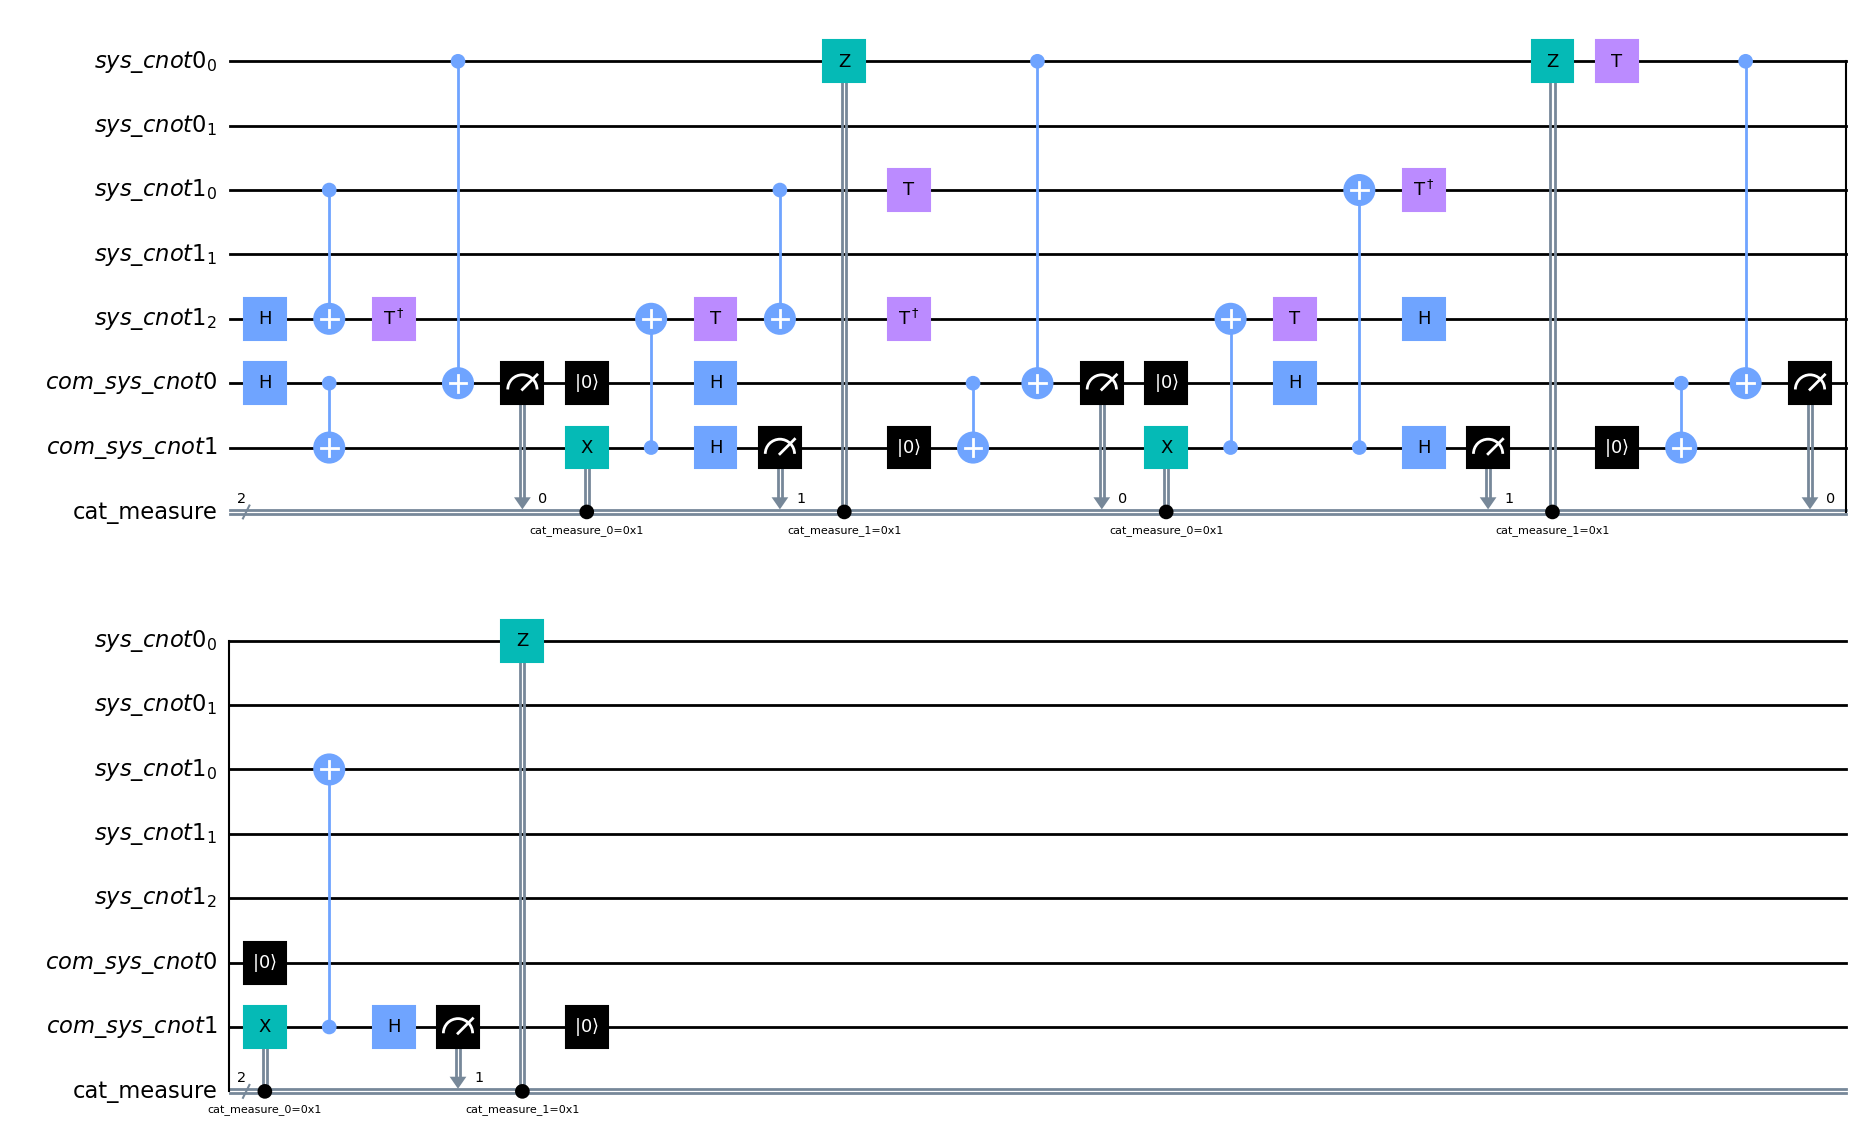

In [16]:
dist_circ = remapper.remap_circuit(qc,decompose=True)
dist_circ.draw(output='mpl')

To bypass one needs to put decompose=True which shall iteratively perform decomposition until circuit is ready for distribution.

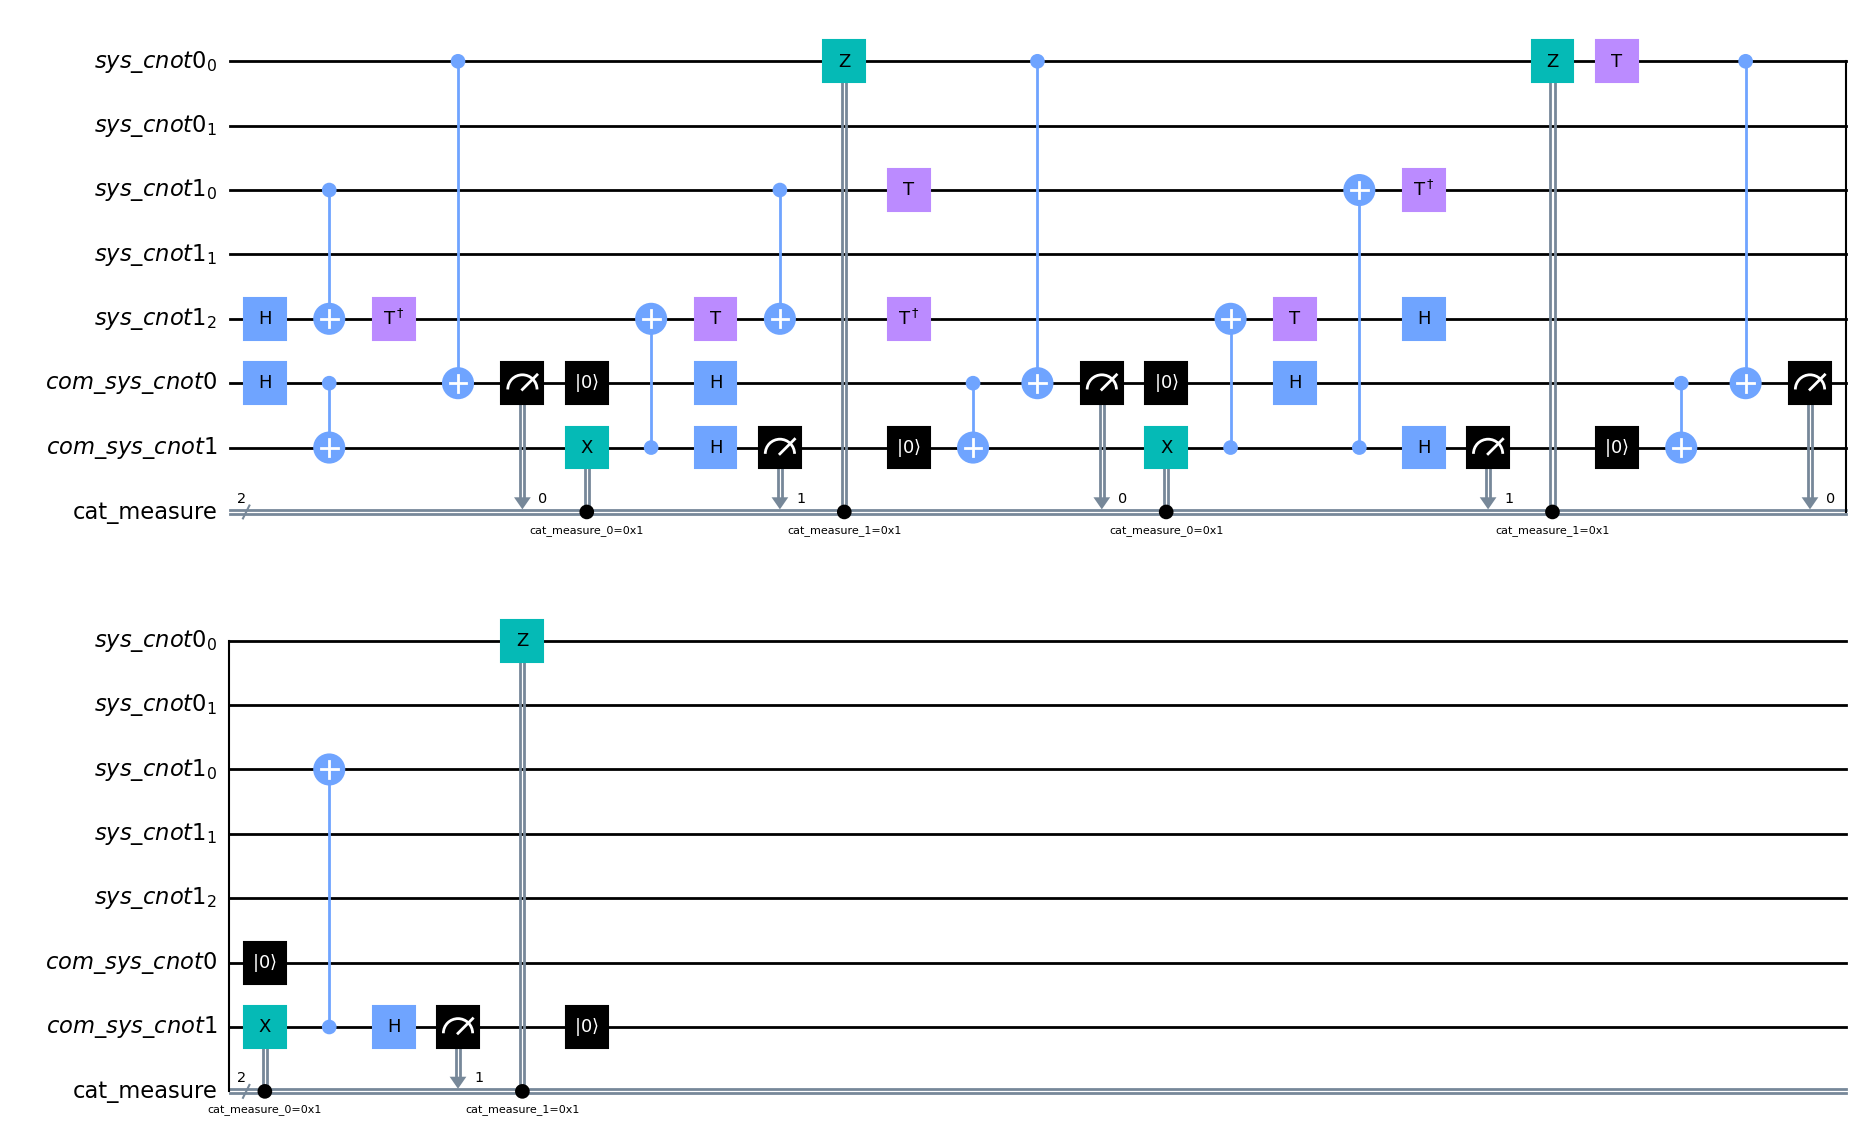

In [17]:
dist_circ = remapper.remap_circuit(qc, decompose=True)
dist_circ.draw(output='mpl')

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table